In [1]:
import re
import string
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, f1_score, precision_score, 
                             recall_score, roc_auc_score, precision_recall_curve,
                             average_precision_score, classification_report)
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nilavans/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/nilavans/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
df = pd.read_csv('data/spam.csv')

In [4]:
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nClass Distribution:")
print(df['label'].value_counts())
print(f"\nSpam percentage: {df['label'].mean():.2%}")

Dataset Shape: (83448, 2)

First few rows:
   label                                               text
0      1  ounce feather bowl hummingbird opec moment ala...
1      1  wulvob get your medircations online qnb ikud v...
2      0   computer connection from cnn com wednesday es...
3      1  university degree obtain a prosperous future m...
4      0  thanks for all your answers guys i know i shou...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83448 entries, 0 to 83447
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   83448 non-null  int64 
 1   text    83448 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.3+ MB
None

Class Distribution:
label
1    43910
0    39538
Name: count, dtype: int64

Spam percentage: 52.62%


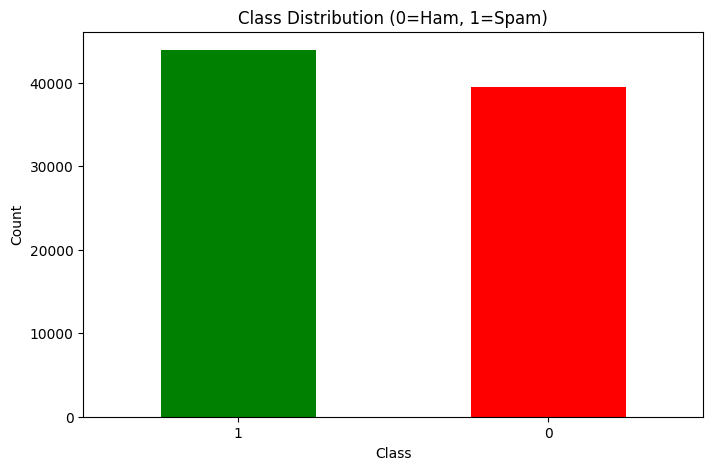

In [5]:
plt.figure(figsize=(8, 5))
df['label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Class Distribution (0=Ham, 1=Spam)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [6]:
df['length'] = df['text'].apply(len)
print("\nMessage Length Statistics by Class:")
print(df.groupby('label')['length'].describe())


Message Length Statistics by Class:
         count         mean          std  min    25%     50%     75%       max
label                                                                         
0      39538.0  2121.693814  5666.075286  1.0  579.0  1139.0  2174.0  598705.0
1      43910.0  1249.887247  1978.631507  1.0  360.0   704.0  1510.0  144087.0


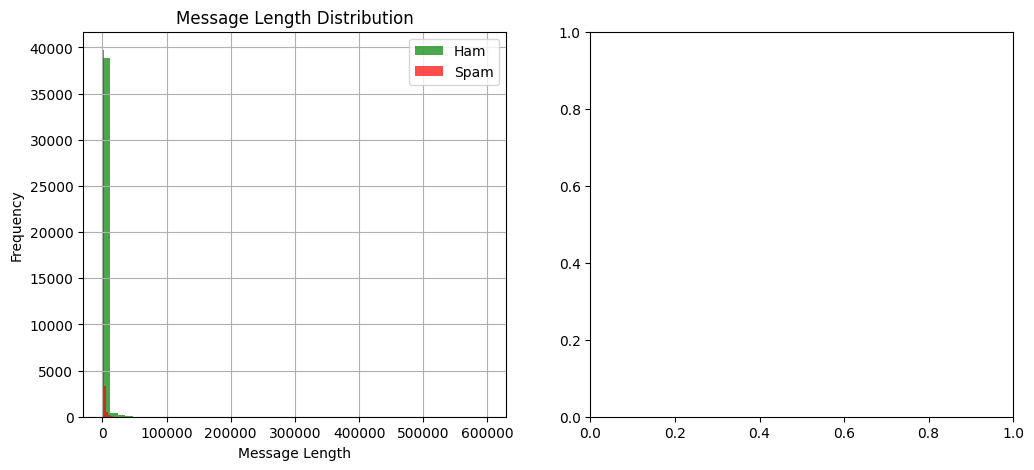

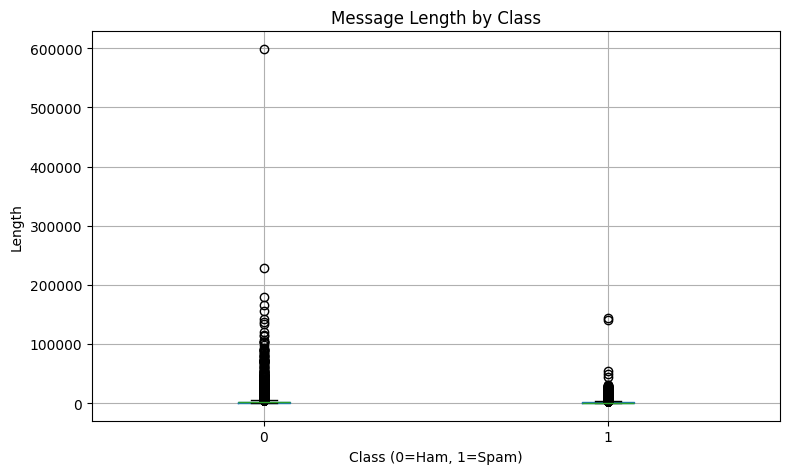

In [7]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df[df['label'] == 0]['length'].hist(bins=50, alpha=0.7, label='Ham', color='green')
df[df['label'] == 1]['length'].hist(bins=50, alpha=0.7, label='Spam', color='red')
plt.legend()
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.title('Message Length Distribution')

plt.subplot(1, 2, 2)
df.boxplot(column='length', by='label', figsize=(8, 5))
plt.suptitle('')
plt.title('Message Length by Class')
plt.xlabel('Class (0=Ham, 1=Spam)')
plt.ylabel('Length')
plt.tight_layout()
plt.show()

In [8]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
print("\nAverage word count by class:")
print(df.groupby('label')['word_count'].mean())


Average word count by class:
label
0    365.057944
1    208.754634
Name: word_count, dtype: float64


In [9]:
spam_words = ' '.join(df[df['label'] == 1]['text']).split()
ham_words = ' '.join(df[df['label'] == 0]['text']).split()

print("Most common SPAM words:")
for word, count in Counter(spam_words).most_common(20):
    print(f"{word}: {count}")

print("Most common HAM words:")
for word, count in Counter(ham_words).most_common(20):
    print(f"{word}: {count}")

Most common SPAM words:
escapenumber: 333179
the: 265488
.: 196760
escapelong: 188102
to: 181924
and: 166689
of: 150490
,: 126591
a: 124457
you: 112841
in: 93112
-: 80347
for: 77062
is: 72193
your: 71510
this: 60544
i: 55807
that: 50849
with: 48463
be: 44237
Most common HAM words:
escapenumber: 798212
the: 454666
to: 296449
-: 292331
.: 255980
,: 207749
a: 189245
and: 188934
of: 186608
in: 152904
/: 120002
for: 114146
i: 112811
is: 109989
:: 104150
on: 97014
that: 88748
this: 75116
you: 74268
it: 68229


In [ ]:
def preprocess_text(text):
    
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 3. Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # 4. Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # 5. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 6. Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 7. Tokenize
    words = word_tokenize(text)
    
    # 8. Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    return ' '.join(words)

# Apply preprocessing
print("Preprocessing text...")
df['clean_text'] = df['text'].apply(preprocess_text)

# Show example
print("\nPreprocessing Example:")
print(f"Original: {df['text'].iloc[0]}")
print(f"Cleaned:  {df['clean_text'].iloc[0]}")

Preprocessing text...


In [ ]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training spam rate: {y_train.mean():.2%}")
print(f"Test spam rate: {y_test.mean():.2%}")

In [ ]:
MAX_WORDS = 5000
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

print(f"\nVocabulary size: {len(tokenizer.word_index)}")
print(f"Using top {MAX_WORDS} words")

print(f"\nExample tokenization:")
print(f"Text: {X_train.iloc[0]}")
print(f"Sequence: {X_train_sequences[0][:20]}...")

In [ ]:
lengths = [len(seq) for seq in X_train_sequences]
average_length = np.mean(lengths)
max_length = np.max(lengths)
percentile_95 = np.percentile(lengths, 95)

print(f"\nSequence length statistics:")
print(f"Average: {average_length:.2f}")
print(f"Max: {max_length}")
print(f"95th percentile: {percentile_95:.2f}")

MAX_LEN = 100
print(f"\nUsing MAX_LEN = {MAX_LEN}")

In [ ]:
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_LEN, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_LEN, padding='post')

print(f"\nPadded training data shape: {X_train_padded.shape}")
print(f"Padded test data shape: {X_test_padded.shape}")

In [ ]:
y_train_encoded = y_train.values
y_test_encoded = y_test.values

print(f"\nLabel distribution in training: {np.bincount(y_train_encoded)}")
print(f"Label distribution in test: {np.bincount(y_test_encoded)}")

In [ ]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"\nClass weights: {class_weight_dict}")
print(f"Spam class will be weighted {class_weights[1]/class_weights[0]:.2f}x more than ham")

In [ ]:
EMBEDDING_DIM = 128
LSTM_UNITS = 64

model = Sequential([
    Embedding(MAX_WORDS, EMBEDDING_DIM),
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

print("\nModel Architecture:")
model.summary()

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_spam_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
print("\nTraining model...")
history = model.fit(
    X_train_padded, y_train_encoded,
    batch_size=64,  
    epochs=20,
    validation_data=(X_test_padded, y_test_encoded),
    class_weight=class_weight_dict,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train')
axes[0, 1].plot(history.history['val_loss'], label='Validation')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train')
axes[1, 0].plot(history.history['val_precision'], label='Validation')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train')
axes[1, 1].plot(history.history['val_recall'], label='Validation')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
y_pred_prob = model.predict(X_test_padded).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate metrics
print("\n" + "="*70)
print("EVALUATION METRICS")
print("="*70)

print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, 
                           target_names=['Ham', 'Spam'],
                           digits=4))

# Individual metrics
precision = precision_score(y_test_encoded, y_pred)
recall = recall_score(y_test_encoded, y_pred)
f1 = f1_score(y_test_encoded, y_pred)
roc_auc = roc_auc_score(y_test_encoded, y_pred_prob)

print(f"\nPrecision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1 Score:  {f1:.4f} ({f1*100:.2f}%)")
print(f"ROC-AUC:   {roc_auc:.4f}")

In [ ]:
cm = confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (Ham correctly classified):  {tn}")
print(f"False Positives (Ham misclassified as Spam): {fp}")
print(f"False Negatives (Spam misclassified as Ham): {fn}")
print(f"True Positives (Spam correctly classified):  {tp}")

In [ ]:
precision_curve, recall_curve, thresholds = precision_recall_curve(y_test_encoded, y_pred_prob)
ap_score = average_precision_score(y_test_encoded, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, marker='.', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AP = {ap_score:.4f})')
plt.grid(True)
plt.show()

print(f"\nAverage Precision Score: {ap_score:.4f}")

In [ ]:
def predict_spam(message, tokenizer, model, max_len=MAX_LEN):
    # Preprocess
    clean_msg = preprocess_text(message)
    
    # Tokenize and pad
    sequence = tokenizer.texts_to_sequences([clean_msg])
    padded = pad_sequences(sequence, maxlen=max_len, padding='post')
    
    # Predict
    prob = model.predict(padded, verbose=0)[0][0]
    label = "SPAM" if prob > 0.5 else "HAM"
    
    return label, prob

In [ ]:
test_messages = [
    "Hi, can we meet at 5pm tomorrow?",
    "WINNER! You've won £1000 cash prize! Call now!",
    "Don't forget to pick up milk on your way home",
    "Congratulations! Click here for your FREE iPhone!",
    "Are you free for lunch next week?",
    "URGENT! Your account will be closed. Click link immediately!",
    "Thanks for the meeting today. Looking forward to our next discussion.",
    "Free entry in 2 a weekly comp to win FA Cup final tickets!"
]

print("\n" + "="*80)
print("SPAM DETECTION RESULTS ON TEST MESSAGES")
print("="*80)

for msg in test_messages:
    label, prob = predict_spam(msg, tokenizer, model)
    print(f"\nMessage: {msg}")
    print(f"Prediction: {label}")
    print(f"Confidence: {prob:.2%}")
    print("-" * 80)